In [28]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# import data and do final prepare for tree models
data_file = os.path.join(os.getcwd(), 'data', 'oregon_washington_combined_data.pkl')
hospital_data = pd.read_pickle(data_file)
hospital_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7100 entries, 0 to 7099
Columns: 138 entries, Hospital_License_or_AHA to Pct_Inc_Total_Revenue_Next_Year
dtypes: float64(2), int64(133), object(3)
memory usage: 7.5+ MB


In [3]:
percent_missing = 100 * hospital_data['Pct_Inc_Total_Revenue_Next_Year'].isna().sum() / hospital_data.shape[0]
print(f'Rows with missing target: {percent_missing:.2f}%')

Rows with missing target: 20.46%


In [4]:
# remove rows with missing target or inf target
hospital_data = hospital_data.dropna()
hospital_data = hospital_data[~np.isinf(hospital_data['Pct_Inc_Total_Revenue_Next_Year'])]
hospital_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5583 entries, 4 to 7095
Columns: 138 entries, Hospital_License_or_AHA to Pct_Inc_Total_Revenue_Next_Year
dtypes: float64(2), int64(133), object(3)
memory usage: 5.9+ MB


In [5]:
validation_cutoff_year = 2022

test_data = hospital_data[hospital_data['Year'] >= validation_cutoff_year]
train_data = hospital_data[hospital_data['Year'] < validation_cutoff_year]
or_train_data = train_data[train_data['State'] == 'Oregon']
or_test_data = test_data[test_data['State'] == 'Oregon']
wa_train_data = train_data[train_data['State'] == 'Washington']
wa_test_data = test_data[test_data['State'] == 'Washington']


or_train_prop = 100 * or_train_data.shape[0] / train_data.shape[0]
or_test_prop = 100 * or_test_data.shape[0] / test_data.shape[0]
wa_train_prop = 100 * wa_train_data.shape[0] / train_data.shape[0]
wa_test_prop = 100 * wa_test_data.shape[0] / test_data.shape[0]
print(f'Training Pct of Overall: {100 * or_train_data.shape[0] / hospital_data.shape[0]:.2f}%')
print(f'Test Set Breakdown: (WA: {wa_test_prop:.2f}%)  (OR: {or_test_prop:.2f}%)')
print(f'Train Set Breakdown: (WA: {wa_train_prop:.2f}%)  (OR: {or_train_prop:.2f}%)')

train_x = train_data.drop(columns=['Hospital_License_or_AHA', 
                                   'Year',
                                   'Hospital_Name',
                                   'Next_Year_Total_Revenue',
                                   'Pct_Inc_Total_Revenue_Next_Year'])
train_x['State_Is_Oregon'] = (train_x['State'] == 'Oregon').astype('int')
train_x.drop(columns=['State'], inplace=True)
test_x = test_data.drop(columns=['Hospital_License_or_AHA', 
                                   'Year',
                                   'Hospital_Name',
                                   'Next_Year_Total_Revenue',
                                   'Pct_Inc_Total_Revenue_Next_Year'])
test_x['State_Is_Oregon'] = (test_x['State'] == 'Oregon').astype('int')
test_x.drop(columns=['State'], inplace=True)
train_y = train_data['Pct_Inc_Total_Revenue_Next_Year']
test_y = test_data['Pct_Inc_Total_Revenue_Next_Year']

Training Pct of Overall: 57.60%
Test Set Breakdown: (WA: 60.65%)  (OR: 39.35%)
Train Set Breakdown: (WA: 26.51%)  (OR: 73.49%)


In [6]:
np.isinf(train_y).sum()

np.int64(0)

### Tuning Boosted Model with CV score

In [7]:
# tuning boosted model with cv score
gbr_model = GradientBoostingRegressor()

param_grid = {
    'n_estimators': [10, 25, 50, 100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(
    estimator=gbr_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error', 
    cv=5,
    n_jobs=-1,  # use all cores
    verbose=1
)

grid_search.fit(train_x, train_y)

# print best parameters
print("Best parameters:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 10}
Best CV score: -626.2797904803945


{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 10}
-626.2797904803945


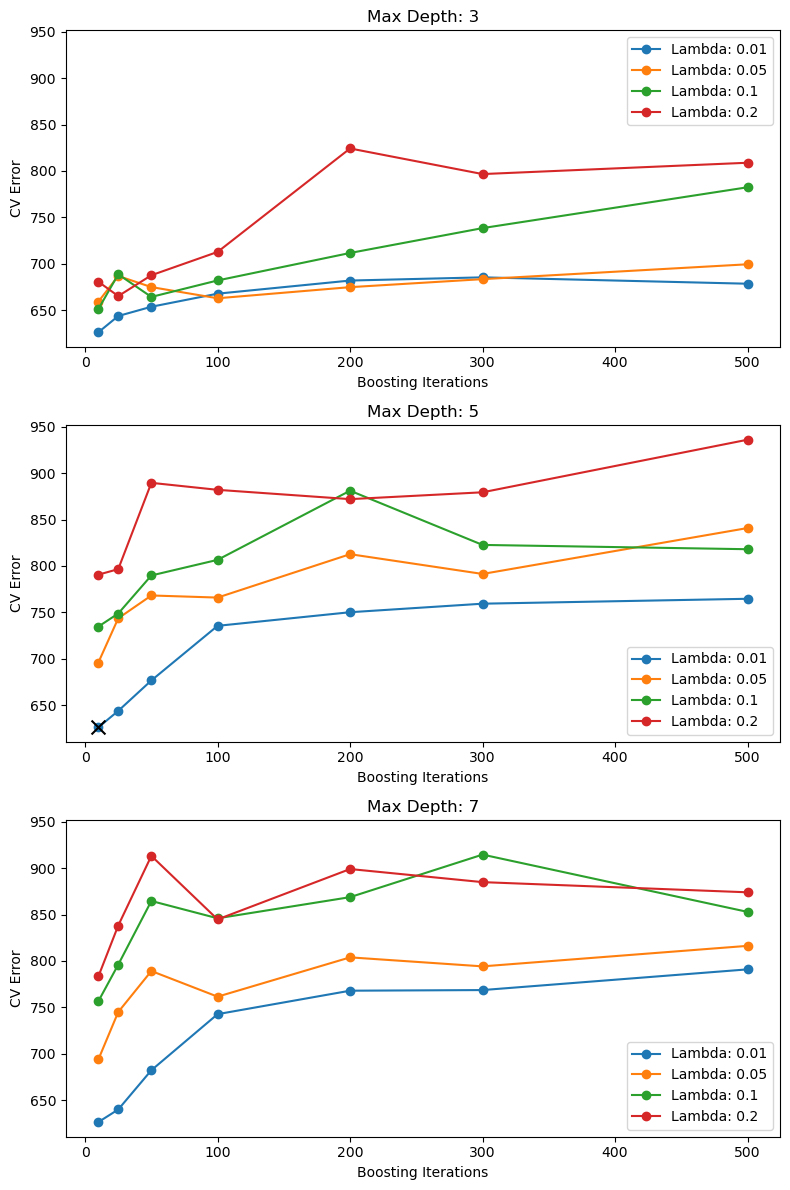

In [26]:
# plots
plot_dir = os.path.join(os.getcwd(), 'plots', 'tree_models')
data_dir = os.path.join(os.getcwd(), 'data', 'tree_models')

tune_results_df = pd.DataFrame(grid_search.cv_results_)

tune_results_df['max_depth']     = tune_results_df['param_max_depth'].astype(int)
tune_results_df['learning_rate'] = tune_results_df['param_learning_rate'].astype(float)
tune_results_df['n_estimators']  = tune_results_df['param_n_estimators'].astype(int)

# get mse from neg_mse
tune_results_df['cv_error'] = -tune_results_df['mean_test_score']

tune_results_df = tune_results_df[['max_depth', 'learning_rate', 'n_estimators', 'cv_error']]
tune_results_df.to_csv(os.path.join(data_dir, 'boosting_cv_tune_results.csv'), index=False)
tune_results_df.to_pickle(os.path.join(data_dir, 'boosting_cv_tune_results.pkl'))

depth_values = sorted(tune_results_df['max_depth'].unique())
lambda_values    = sorted(tune_results_df['learning_rate'].unique())

fig, axes = plt.subplots(nrows=len(depth_values), ncols=1, sharey=True, figsize=(8, 12))

for ax, depth in zip(axes, depth_values):
    df_depth = tune_results_df[tune_results_df['max_depth'] == depth]
    
    for learn_rate in lambda_values:
        # subset by learning rate lambda and sort by number of trees.
        df_lr = df_depth[df_depth['learning_rate'] == learn_rate].sort_values('n_estimators')
        ax.plot(df_lr['n_estimators'], df_lr['cv_error'], marker='o', label=f"Lambda: {learn_rate}")

    if depth == grid_search.best_params_['max_depth']:
        print(grid_search.best_params_)
        print(grid_search.best_score_)
        ax.scatter(x=[grid_search.best_params_['n_estimators']], y=[-grid_search.best_score_],
                   marker='x', color='black', s=100, zorder=1000)
    
    ax.set_title(f"Max Depth: {depth}")
    ax.set_xlabel("Boosting Iterations")
    ax.set_ylabel("CV Error")
    ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'boosting_cv_tune_results.png'))
plt.show()

In [51]:
# final model evaluation
sklearn_gbr_model = grid_search.best_estimator_
sklearn_gbr_pred = sklearn_gbr_model.predict(test_x)
print(f'Sklearn GBR MSE: {mean_squared_error(test_y, sklearn_gbr_pred)}')
print(f'R-squared: {r2_score(test_y, sklearn_gbr_pred)}')

same_sign = ((sklearn_gbr_pred * test_y) > 0)
pct_same_sign = np.sum(same_sign) / same_sign.shape[0]
print(f'Percent of predictions same sign as actual: {100 * pct_same_sign:.2f}%')
print(f'Percent positive predictions: {100 * np.sum(sklearn_gbr_pred > 0) / sklearn_gbr_pred.shape[0]:.2f}%')

Sklearn GBR MSE: 15681.043079172623
R-squared: 0.015935285260242016
Percent of predictions same sign as actual: 83.93%
Percent positive predictions: 100.00%


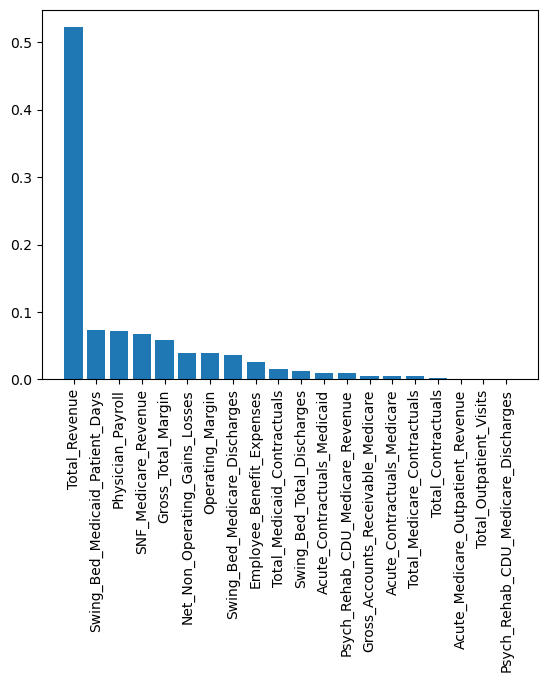

In [54]:
importances = sklearn_gbr_model.feature_importances_
feature_names = sklearn_gbr_model.feature_names_in_
indices = np.argsort(importances)[::-1][:20] # take top 20
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), np.array(feature_names)[indices], rotation=90)
plt.show()

In [46]:
# What is the mse of a model that just assumes normal distribution of the target and randomly guesses?

guess_model = np.random.normal(np.mean(test_y), np.std(test_y), test_y.shape[0])

print(f'Guessing (normal) MSE: {mean_squared_error(test_y, guess_model)}')
print(f'Guessing R-squared: {r2_score(test_y, guess_model)}')

guess_model = np.random.lognormal(np.mean(np.log(test_y+0.0001)), np.std(np.log(test_y+0.0001)), test_y.shape[0]) - 0.0001

print(f'Guessing (lognormal) MSE: {mean_squared_error(test_y, guess_model)}')
print(f'Guessing R-squared: {r2_score(test_y, guess_model)}')

Guessing (normal) MSE: 31657.10881011661
Guessing R-squared: -0.9866435921019472
Guessing (lognormal) MSE: 17373.419160811463
Guessing R-squared: -0.09026986815983173


c:\Users\ellin\miniconda3\envs\keras_dl\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [39]:
np.max(np.concat([train_y, test_y]))

np.float64(3858.525880791506)

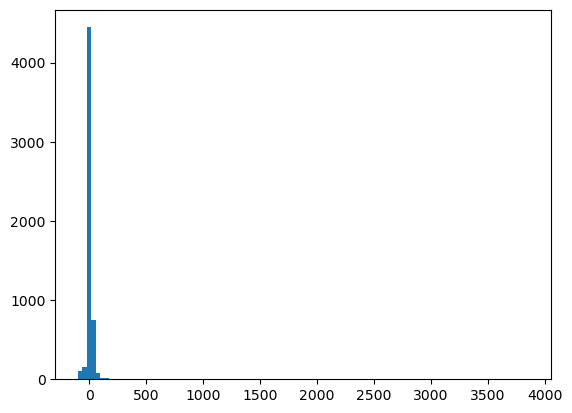

In [38]:
plt.hist(np.concat([train_y, test_y]), bins=100)
plt.show()

### Tuning boosted model with predefined tuning validation set

In [ ]:
# tuning